In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

breast_cancer = pd.read_csv('breast_cancer_wisconsin.csv')
hepatitis = pd.read_csv('hepatitis.csv')

breast_cancer.head(10)

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


In [2]:
hepatitis = hepatitis[~hepatitis.eq('?').any(1)].astype(float)
breast_cancer = breast_cancer[~breast_cancer.eq('?').any(1)].astype(float)

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
count,80.000000,80.00000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00000
mean,1.837500,40.66250,1.137500,1.525000,1.737500,1.350000,1.612500,1.850000,1.837500,1.525000,1.812500,1.687500,1.850000,1.875000,1.221250,102.912500,82.025000,3.843750,62.512500,1.41250
std,0.371236,11.28003,0.346547,0.502525,0.442769,0.479979,0.490253,0.359324,0.371236,0.502525,0.392775,0.466437,0.359324,0.332805,0.875213,53.684779,71.599974,0.576292,23.427774,0.49539
min,1.000000,20.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.300000,26.000000,14.000000,2.100000,0.000000,1.00000
25%,2.000000,32.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.700000,68.250000,30.750000,3.500000,46.000000,1.00000
50%,2.000000,38.50000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,85.000000,56.500000,4.000000,62.000000,1.00000
75%,2.000000,49.25000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.300000,133.500000,102.750000,4.200000,77.250000,2.00000
max,2.000000,72.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.800000,280.000000,420.000000,5.000000,100.000000,2.00000


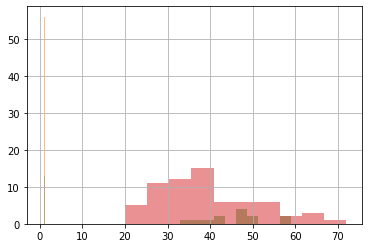

In [3]:
len(hepatitis.loc[hepatitis['Class'] == 2].index), len(hepatitis.loc[hepatitis['Class'] == 1].index)
hepatitis.groupby('Class').SEX.hist(alpha=0.5)
hepatitis.groupby('Class').AGE.hist(alpha=0.5)
hepatitis.describe()

Class
2.0    AxesSubplot(0.125,0.125;0.775x0.755)
4.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Mitoses, dtype: object

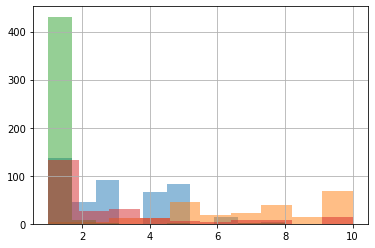

In [4]:
len(breast_cancer.loc[breast_cancer['Class'] == 2].index), len(breast_cancer.loc[breast_cancer['Class'] == 1].index)
breast_cancer.groupby('Class').Clump_Thickness.hist(alpha=0.5)
breast_cancer.groupby('Class').Mitoses.hist(alpha=0.5)

In [5]:
np_hepatitis = hepatitis.to_numpy()
np_breast_cancer = breast_cancer.to_numpy()

shuffler_hepa = np.random.permutation(len(np_hepatitis))
shuffler_breast = np.random.permutation(len(np_breast_cancer))

hepatitis_y = np_hepatitis[shuffler_hepa][:,0]
hepatitis_x = np_hepatitis[shuffler_hepa][:,1:]

breast_cancer_x = np_breast_cancer[shuffler_breast][:,1:-1]
breast_cancer_y = np_breast_cancer[shuffler_breast][:,-1]

# KNN Class Implementation

In [6]:
# euclidean distance
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
euclidean.__name__ = 'euclidean'

# manhattan distance
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)
manhattan.__name__ = 'manhattan'

# hamming distance
hamming = lambda x1, x2: np.sum(np.equal(x1, x2), axis=-1)
hamming.__name__ = 'hamming'

# hepatitis_euclidean distance
hepatitis_euclidean = lambda x1, x2: euclidean(np.take(x1, [0, 13, 14, 15, 16, 17], axis=-1), np.take(x2, [0, 13, 14, 15, 16, 17], axis=-1)) + hamming(np.delete(x1, [0, 13, 14, 15, 16, 17], axis=-1), np.delete(x2, [0, 13, 14, 15, 16, 17], axis=-1))
hepatitis_euclidean.__name__ = 'hepatitis euclidean'

# hepatitis_manhattan distance
hepatitis_manhattan = lambda x1, x2: manhattan(np.take(x1, [0, 13, 14, 15, 16, 17], axis=-1), np.take(x2, [0, 13, 14, 15, 16, 17], axis=-1)) + hamming(np.delete(x1, [0, 13, 14, 15, 16, 17], axis=-1), np.delete(x2, [0, 13, 14, 15, 16, 17], axis=-1))
hepatitis_manhattan.__name__ = 'hepatitis manhattan'

class KNN:
    def __init__(self, K=1, dist_fn=euclidean):
        """KNN constructor

        :param K int: K value in KNN
        """
        self.K = K
        self.dist_fn = dist_fn

    def fit(self, x, y):
        """Train the model lazily

        Store the training data using this method as it is a lazy learner.

        :param x: dataset on the x-axis
        :param y: dataset on the y-axis
        """
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self

    def predict(self, x_test):
        """Make a prediction for the given data

        Make a prediction using the stored training data and the test data given as argument

        :param x_test: test dataset that is being classified
        """
        num_test = x_test.shape[0]
        #calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

    def evaluate_acc(self, true, target):
        return np.count_nonzero(true == target)/len(true)

# Decision Tree Implementation

In [7]:
class Node:
  def __init__(self, data_indices, parent):
    """Node constructor

    Construct a new Node instance to be used to build a decistion tree.

    :param data_indices: stores the data indices whic are in the region defined by this node
    :param parent Node: parent Node of the node instance, helps with traversing the tree
    """

    # stores the data indices which are in the region defined by this node
    self.data_indices = data_indices

    # stores the left child of the node
    self.left = None

    # stores the right child of the node
    self.right = None

    # the feature for split at this node
    self.split_feature = None

    # the value of the feature for split at this node
    self.split_value = None

    # if a parent node is given
    if parent:

      # obtain the depth of the node by adding one to the depth of the parent
      self.depth = parent.depth + 1

      # copies the number of classes from the parent
      self.num_classes = parent.num_classes

      # copies the data from the parent
      self.data = parent.data

      # copies the labels from the parent
      self.labels = parent.labels

      # this is count frequency of different labels in the region defined by this node
      class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes)

      # stores the class probability for the node
      self.class_prob = class_prob / np.sum(class_prob)

In [8]:
def greedy_test(node, cost_fn):
  """Greedy splitting of a node

  Given a node, we consider all possible feature-value combinations for splitting the data.
  One such test that produces the lowest cost according to a supplied cost function (cost_fn) is returned.

  :param node Node: a node of the decision tree.
  :param cost_fn function: a cost function.
  """

  # initialize the best parameter values
  best_cost = np.inf
  best_feature, best_value = None, None
  num_instances, num_features = node.data.shape
  
  # sort the features to get the test value candidates by taking the average of consecutive sorted feature values
  data_sorted = np.sort(node.data[node.data_indices], axis=0)
  test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2
  for f in range(num_features):

    # stores the data corresponding to the f-th feature
    data_f = node.data[node.data_indices, f]
    for test in test_candidates[:, f]:

      # split the indices using the test value of f-th feature
      left_indices = node.data_indices[data_f <= test]
      right_indices = node.data_indices[data_f > test]

      # we can't have a split where a child has zero element
      # if this is true over all the test features and their test values then
      # the function returns the best cost as infinity
      if len(left_indices) == 0 or len(right_indices) == 0:
        continue
      
      # compute the left and right cost based on the current split
      left_cost = cost_fn(node.labels[left_indices])
      right_cost = cost_fn(node.labels[right_indices])
      num_left, num_right = left_indices.shape[0], right_indices.shape[0]

      # get the combined cost using the weighted sum of left and right cost
      cost = (num_left * left_cost + num_right * right_cost) / num_instances

      # update only when a lower cost is encountered
      if cost < best_cost:
        best_cost = cost
        best_feature = f
        best_value = test
  return best_cost, best_feature, best_value

In [9]:
# cost functions
def misclassification_cost(labels):
  """
  computes misclassification cost by subtracting the maximum probability of any class.
  """

  class_probs = np.bincount(labels) / len(labels)
  return 1 - np.max(class_probs)

def entropy_cost(labels):
  """
  computes entropy of the labels by computing the class probabilities
  """

  class_probs = np.bincount(labels) / len(labels)

  # remove 0 probabilities to remove numerical issues while computing log
  class_probs = class_probs[class_probs > 0]

  # expression for entropy = -\sigma p(x)log(p(x))
  return -np.sum(class_probs * np.log(class_probs))

def gini_index_cost(labels):
  """
  computes the gini index cost
  """

  class_probs = np.bincount(labels) / len(labels)
  
  # expression for gini index = 1 - \sigma p(x)^2
  return 1 - np.sum(np.square(class_probs)) 

In [10]:
class DecisionTree:
  def __init__(self, num_classes=None, max_depth=3, cost_fn=misclassification_cost, min_leaf_instances=1):
    """Decision Tree constructor
    
    :param num_classes int: total number of classes
    :param max_depth int: maximum depth for termination
    :param cost_fn function: cost function of the decision tree
    :param min_leaf_instances int: minimum number of instances in a leaf for termination
    """

    self.max_depth = max_depth
    self.root = None
    self.cost_fn = cost_fn
    self.num_classes = num_classes
    self.min_leaf_instances = min_leaf_instances

  def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
      self.num_classes = np.max(labels) + 1
    
    # initialize the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0

    # recursively build the rest of the tree
    self._fit_tree(self.root)

  def predict(self, test_data):
    class_probs = np.zeros((test_data.shape[0], self.num_classes))
    for n, x in enumerate(test_data):
      node = self.root

      # loop along the depth of the tree looking for the region where the present data sample fall in
      # based on the split feature and value
      while node.left:
        if x[node.split_feature] <= node.split_value:
          node = node.left
        else:
          node = node.right
      
      # the loop terminates when it reaches a leaf of the tree and the class probability of that node is
      # taken for prediction
      class_probs[n, :] = node.class_prob
    return class_probs

  def evaluate_acc(self, true, target):
    return np.count_nonzero(true == target)/len(true)
  
  def _fit_tree(self, node):
    
    # the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
      return
    
    # greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)

    # if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
      return
    
    # get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices, split_feature] <= split_value

    # store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value

    # define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)

    # recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)

    # assign the left and right child to present child
    node.left = left
    node.right = right

# Experiments

In [11]:
# hepatitis training data
hx_train, hy_train = hepatitis_x[:40], hepatitis_y[:40]

# hepatitis test data
hx_test, hy_test = hepatitis_x[40:], hepatitis_y[40:]

# breast cancer training data
bcx_train, bcy_train = breast_cancer_x[:400], breast_cancer_y[:400]

# breast cancer test data
bcx_test, bcy_test = breast_cancer_x[400:], breast_cancer_y[400:]

# normalize hepatitis data
hx_train_normalized = hx_train / [80., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4., 250., 500., 6., 90., 1]
hx_test_normalized = hx_test / [80., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4., 250., 500., 6., 90., 1]

## Decision Tree Experiments

accuracy is 82.5.


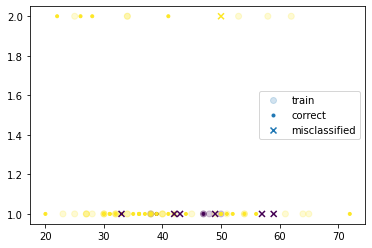

In [12]:
# hepatitis data classification
hepatitis_tree = DecisionTree()
hepatitis_tree.fit(hx_train, hy_train.astype('int64'))
probs_test = hepatitis_tree.predict(hx_test)
hepatitis_prediction = np.argmax(probs_test, 1)
accuracy = hepatitis_tree.evaluate_acc(hepatitis_prediction, hy_test)
print(f'accuracy is {accuracy*100:.1f}.')
# visualization
correct = hy_test == hepatitis_prediction
incorrect = np.logical_not(correct)
plt.scatter(hx_train[:, 0], hx_train[:, 1], c=hy_train, marker='o', alpha=.2, label='train')
plt.scatter(hx_test[correct, 0], hx_test[correct, 1], marker='.', c=hepatitis_prediction[correct], label='correct')
plt.scatter(hx_test[incorrect, 0], hx_test[incorrect, 1], marker='x', c=hy_test[incorrect], label='misclassified')
plt.legend()
plt.show()

accuracy is 82.5.


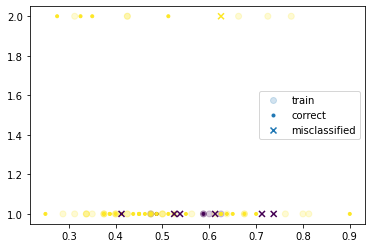

In [13]:
# hepatitis data classification
hepatitis_tree2 = DecisionTree()
hepatitis_tree2.fit(hx_train_normalized, hy_train.astype('int64'))
probs_test2 = hepatitis_tree2.predict(hx_test_normalized)
hepatitis_prediction2 = np.argmax(probs_test2, 1)
accuracy2 = hepatitis_tree2.evaluate_acc(hepatitis_prediction2, hy_test)
print(f'accuracy is {accuracy2*100:.1f}.')
# visualization
correct2 = hy_test == hepatitis_prediction2
incorrect2 = np.logical_not(correct2)
plt.scatter(hx_train_normalized[:, 0], hx_train_normalized[:, 1], c=hy_train, marker='o', alpha=.2, label='train')
plt.scatter(hx_test_normalized[correct2, 0], hx_test_normalized[correct2, 1], marker='.', c=hepatitis_prediction2[correct2], label='correct')
plt.scatter(hx_test_normalized[incorrect2, 0], hx_test_normalized[incorrect2, 1], marker='x', c=hy_test[incorrect2], label='misclassified')
plt.legend()
plt.show()

accuracy is 95.8.


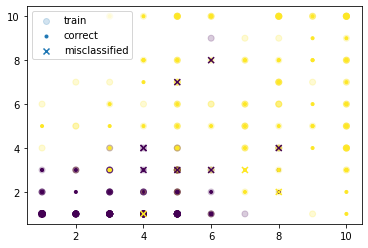

In [14]:
# breast cancer data classification
bc_tree = DecisionTree()
bc_tree.fit(bcx_train, bcy_train.astype('int64'))
dt_prob = bc_tree.predict(bcx_test)
bc_prediction = np.argmax(dt_prob, 1)
accuracy3 = bc_tree.evaluate_acc(bc_prediction, bcy_test)
print(f'accuracy is {accuracy3*100:.1f}.')

# visualization
bc_correct = bcy_test == bc_prediction
bc_incorrect = np.logical_not(bc_correct)
plt.scatter(bcx_train[:, 0], bcx_train[:, 1], c=bcy_train, marker='o', alpha=.2, label='train')
plt.scatter(bcx_test[bc_correct, 0], bcx_test[bc_correct, 1], marker='.', c=bc_prediction[bc_correct], label='correct')
plt.scatter(bcx_test[bc_incorrect, 0], bcx_test[bc_incorrect, 1], marker='x', c=bcy_test[bc_incorrect], label='misclassified')
plt.legend()
plt.show()

### Decision Tree Hyper Parameter Tuning for Breast Cancer Dataset

In [15]:
# performance of decision tree with varying tree depth
accuracies = []
for i in range(3, 21):
  dt = DecisionTree(max_depth=i)
  dt.fit(bcx_train, bcy_train.astype('int64'))
  probs = dt.predict(bcx_test)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, bcy_test)
  accuracy *= 100
  accuracies.append([i, accuracy])

In [16]:
# visualization
df1 = pd.DataFrame(data=np.array(accuracies), columns=['Max Depth', 'Accuracy'])
df1

,Max Depth,Accuracy
0,3.0,95.759717
1,4.0,96.113074
2,5.0,96.113074
3,6.0,96.466431
4,7.0,95.406360
5,8.0,95.406360
6,9.0,95.053004
7,10.0,95.053004
8,11.0,93.992933
9,12.0,93.992933


In [17]:
# performance of decision tree with different cost function
cost_fns = [misclassification_cost, entropy_cost, gini_index_cost]
cost_accuracies = []
for cost in cost_fns:
  dt = DecisionTree(cost_fn=cost)
  dt.fit(bcx_train, bcy_train.astype('int64'))
  probs = dt.predict(bcx_test)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, bcy_test)
  accuracy *= 100
  cost_accuracies.append([cost.__name__, 3, accuracy])

In [18]:
# visualization
df2 = pd.DataFrame(data=np.array(cost_accuracies), columns=['Cost Function', 'Max Depth', 'Accuracy'])
df2

,Cost Function,Max Depth,Accuracy
0,misclassification_cost,3,95.75971731448763
1,entropy_cost,3,96.81978798586573
2,gini_index_cost,3,94.34628975265018


In [19]:
# performance of decision tree with varying max depth and cost functions
max_accuracies = []
for cost in cost_fns:
  for i in range(3, 16):
    dt = DecisionTree(max_depth=i, cost_fn=cost)
    dt.fit(bcx_train, bcy_train.astype('int64'))
    probs = dt.predict(bcx_test)
    prediction = np.argmax(probs, 1)
    accuracy =dt.evaluate_acc(prediction, bcy_test)
    accuracy *= 100
    max_accuracies.append([cost.__name__, i, accuracy])

In [20]:
# visualization
df3 = pd.DataFrame(data=np.array(max_accuracies), columns=['Cost Function', 'Max Depth', 'Accuracy'])
df3

,Cost Function,Max Depth,Accuracy
0,misclassification_cost,3,95.75971731448763
1,misclassification_cost,4,96.113074204947
2,misclassification_cost,5,96.113074204947
3,misclassification_cost,6,96.46643109540636
4,misclassification_cost,7,95.40636042402826
5,misclassification_cost,8,95.40636042402826
6,misclassification_cost,9,95.0530035335689
7,misclassification_cost,10,95.0530035335689
8,misclassification_cost,11,93.99293286219081
9,misclassification_cost,12,93.99293286219081


### Decision Tree Hyper Parameter Tuning for Hepatitis Dataset

In [21]:
# performance of decision tree with varying tree depth
h_accuracies = []
for i in range(3, 21):
  dt = DecisionTree(max_depth=i)
  dt.fit(hx_train, hy_train.astype('int64'))
  probs = dt.predict(hx_test)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, hy_test)
  accuracy *= 100
  h_accuracies.append([i, accuracy])

In [22]:
# visualization
hdf1 = pd.DataFrame(data=np.array(h_accuracies), columns=['Max Depth', 'Accuracy'])
hdf1

,Max Depth,Accuracy
0,3.0,82.5
1,4.0,82.5
2,5.0,82.5
3,6.0,82.5
4,7.0,82.5
5,8.0,82.5
6,9.0,82.5
7,10.0,82.5
8,11.0,82.5
9,12.0,82.5


In [23]:
# performance of decision tree with different cost function
cost_fns = [misclassification_cost, entropy_cost, gini_index_cost]
h_cost_accuracies = []
for cost in cost_fns:
  dt = DecisionTree(cost_fn=cost)
  dt.fit(hx_train, hy_train.astype('int64'))
  probs = dt.predict(hx_test)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, hy_test)
  accuracy *= 100
  h_cost_accuracies.append([cost.__name__, 3, accuracy])

In [24]:
# visualization
hdf2 = pd.DataFrame(data=np.array(h_cost_accuracies), columns=['Cost Function', 'Max Depth', 'Accuracy'])
hdf2

,Cost Function,Max Depth,Accuracy
0,misclassification_cost,3,82.5
1,entropy_cost,3,82.5
2,gini_index_cost,3,82.5


In [25]:
# performance of decision tree with varying max depth and cost functions
h_max_accuracies = []
for cost in cost_fns:
  for i in range(3, 16):
    dt = DecisionTree(max_depth=i, cost_fn=cost)
    dt.fit(hx_train, hy_train.astype('int64'))
    probs = dt.predict(hx_test)
    prediction = np.argmax(probs, 1)
    accuracy =dt.evaluate_acc(prediction, hy_test)
    accuracy *= 100
    h_max_accuracies.append([cost.__name__, i, accuracy])

In [26]:
# visualization
hdf3 = pd.DataFrame(data=np.array(h_max_accuracies), columns=['Cost Function', 'Max Depth', 'Accuracy'])
hdf3

,Cost Function,Max Depth,Accuracy
0,misclassification_cost,3,82.5
1,misclassification_cost,4,82.5
2,misclassification_cost,5,82.5
3,misclassification_cost,6,82.5
4,misclassification_cost,7,82.5
5,misclassification_cost,8,82.5
6,misclassification_cost,9,82.5
7,misclassification_cost,10,82.5
8,misclassification_cost,11,82.5
9,misclassification_cost,12,82.5


## KNN Experiments



In [27]:
knn = KNN(K=7, dist_fn=euclidean)
knn.fit(bcx_train, bcy_train.astype('int64'))
knn_probs, knns = knn.predict(bcx_test)
knn_pred = np.argmax(knn_probs, 1)
knn_accuracy = knn.evaluate_acc(knn_pred, bcy_test)
print(f'accuracy is {knn_accuracy*100:.1f}.')

accuracy is 97.5.


In [28]:
knn2 = KNN(K=4, dist_fn=hepatitis_euclidean)
knn2.fit(hx_train_normalized, hy_train.astype('int64'))
knn_probs2, knns2 = knn2.predict(hx_test_normalized)
knn_pred2 = np.argmax(knn_probs2, 1)
knn_accuracy2 = knn2.evaluate_acc(knn_pred2, hy_test)
print(f'accuracy is {knn_accuracy2*100:.1f}.')

accuracy is 77.5.


### KNN Hyper Parameter Tuning for Breast Cancer Dataset

In [29]:
knn_accuracies = []
for i in range(2, 21):
  knn = KNN(K=i)
  knn.fit(bcx_train, bcy_train.astype('int64'))
  probs, knns = knn.predict(bcx_test)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, bcy_test)
  accuracy *= 100
  knn_accuracies.append([i, accuracy])

In [30]:
# visualization
kdf1 = pd.DataFrame(data=np.array(knn_accuracies), columns=['K Value', 'Accuracy'])
kdf1

,K Value,Accuracy
0,2.0,96.819788
1,3.0,97.879859
2,4.0,97.879859
3,5.0,97.526502
4,6.0,97.526502
5,7.0,97.526502
6,8.0,97.526502
7,9.0,97.526502
8,10.0,97.526502
9,11.0,97.526502


In [31]:
# performance of decision tree with different cost function
cost_fns = [euclidean, manhattan]
knn_cost_accuracies = []
for cost in cost_fns:
  knn = KNN(dist_fn=cost)
  knn.fit(bcx_train, bcy_train.astype('int64'))
  probs, knns = knn.predict(bcx_test)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, bcy_test)
  accuracy *= 100
  knn_cost_accuracies.append([cost.__name__, 3, accuracy])

In [32]:
# visualization
kdf2 = pd.DataFrame(data=np.array(knn_cost_accuracies), columns=['Cost Function', 'K Value', 'Accuracy'])
kdf2

,Cost Function,K Value,Accuracy
0,euclidean,3,96.81978798586573
1,manhattan,3,96.46643109540636


In [33]:
# performance of decision tree with varying max depth and cost functions
knn_max_accuracies = []
for cost in cost_fns:
  for i in range(3, 16):
    knn = KNN(K=i, dist_fn=cost)
    knn.fit(bcx_train, bcy_train.astype('int64'))
    probs, knns = knn.predict(bcx_test)
    prediction = np.argmax(probs, 1)
    accuracy =dt.evaluate_acc(prediction, bcy_test)
    accuracy *= 100
    knn_max_accuracies.append([cost.__name__, i, accuracy])

In [34]:
# visualization
kdf3 = pd.DataFrame(data=np.array(knn_max_accuracies), columns=['Cost Function', 'K Value', 'Accuracy'])
kdf3

,Cost Function,K Value,Accuracy
0,euclidean,3,97.87985865724382
1,euclidean,4,97.87985865724382
2,euclidean,5,97.52650176678446
3,euclidean,6,97.52650176678446
4,euclidean,7,97.52650176678446
5,euclidean,8,97.52650176678446
6,euclidean,9,97.52650176678446
7,euclidean,10,97.52650176678446
8,euclidean,11,97.52650176678446
9,euclidean,12,97.1731448763251


### KNN Hyperparamter Tuning for Hepatitis Dataset

In [35]:
knn_hp_accuracies = []
for i in range(3, 21):
  knn = KNN(K=i, dist_fn=hepatitis_euclidean)
  knn.fit(hx_train_normalized, hy_train.astype('int64'))
  probs, knns = knn.predict(hx_test_normalized)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, hy_test)
  accuracy *= 100
  knn_hp_accuracies.append([i, accuracy])

In [36]:
# visualization
khpdf1 = pd.DataFrame(data=np.array(knn_hp_accuracies), columns=['K Value', 'Accuracy'])
khpdf1

,K Value,Accuracy
0,3.0,77.5
1,4.0,77.5
2,5.0,77.5
3,6.0,77.5
4,7.0,80.0
5,8.0,80.0
6,9.0,80.0
7,10.0,77.5
8,11.0,80.0
9,12.0,80.0


In [37]:
# performance of decision tree with different cost function
cost_fns = [hepatitis_euclidean, hepatitis_manhattan]
knn_hp_cost_accuracies = []
for cost in cost_fns:
  knn = KNN(dist_fn=cost)
  knn.fit(hx_train_normalized, hy_train.astype('int64'))
  probs, knns = knn.predict(hx_test_normalized)
  prediction = np.argmax(probs, 1)
  accuracy = dt.evaluate_acc(prediction, hy_test)
  accuracy *= 100
  knn_hp_cost_accuracies.append([cost.__name__, 3, accuracy])

In [38]:
# visualization
khpdf2 = pd.DataFrame(data=np.array(knn_hp_cost_accuracies), columns=['Cost Function', 'K Value', 'Accuracy'])
khpdf2

,Cost Function,K Value,Accuracy
0,hepatitis euclidean,3,77.5
1,hepatitis manhattan,3,80.0


In [40]:
# performance of decision tree with varying max depth and cost functions
knn_hp_max_accuracies = []
for cost in cost_fns:
  for i in range(3, 16):
    knn = KNN(K=i, dist_fn=cost)
    knn.fit(hx_train_normalized, hy_train.astype('int64'))
    probs, knns = knn.predict(hx_test_normalized)
    prediction = np.argmax(probs, 1)
    accuracy =dt.evaluate_acc(prediction, hy_test)
    accuracy *= 100
    knn_hp_max_accuracies.append([cost.__name__, i, accuracy])

In [41]:
# visualization
khpdf3 = pd.DataFrame(data=np.array(knn_hp_max_accuracies), columns=['Cost Function', 'K Value', 'Accuracy'])
khpdf3

,Cost Function,K Value,Accuracy
0,hepatitis euclidean,3,77.5
1,hepatitis euclidean,4,77.5
2,hepatitis euclidean,5,77.5
3,hepatitis euclidean,6,77.5
4,hepatitis euclidean,7,80.0
5,hepatitis euclidean,8,80.0
6,hepatitis euclidean,9,80.0
7,hepatitis euclidean,10,77.5
8,hepatitis euclidean,11,80.0
9,hepatitis euclidean,12,80.0


## Cross Validation

In [42]:
def cross_validation_decision_tree(num_splits, max_depth, cost_fn, dataset_x, dataset_y):
  decision_tree = DecisionTree(max_depth=max_depth, cost_fn=cost_fn)
  split_array_x = np.array_split(dataset_x, num_splits)
  split_array_y = np.array_split(dataset_y, num_splits)
  accuracy=0
  for i in range(0,num_splits):
    test_x, test_y = split_array_x[i], split_array_y[i]
    train_x, train_y = np.concatenate(np.delete(split_array_x, 2)), np.concatenate(np.delete(split_array_y, 2))

    decision_tree.fit(train_x, train_y.astype('int64'))
    probs_test = decision_tree.predict(test_x)
    prediction = np.argmax(probs_test, 1)
    accuracy += decision_tree.evaluate_acc(prediction, test_y)*100
  
  return accuracy/num_splits

In [43]:
def cross_validation_knn(num_splits, k_value, dist_fn, dataset_x, dataset_y):
  knn = KNN(K=k_value, dist_fn=dist_fn)
  split_array_x = np.array_split(dataset_x, num_splits)
  split_array_y = np.array_split(dataset_y, num_splits)
  accuracy=0
  for i in range(0,num_splits):
    test_x, test_y = split_array_x[i], split_array_y[i]
    train_x, train_y = np.concatenate(np.delete(split_array_x, 2)), np.concatenate(np.delete(split_array_y, 2))

    knn.fit(train_x, train_y.astype('int64'))
    probs_test, knns = knn.predict(test_x)
    prediction = np.argmax(probs_test, 1)
    accuracy += knn.evaluate_acc(prediction, test_y)*100
  
  return accuracy/num_splits

In [44]:
# performance of decision tree with varying max depth and cost functions
cost_fns = [misclassification_cost, entropy_cost, gini_index_cost]
max_accuracies = []
# for cost in cost_fns:
for i in range(3, 13):
  accuracy = cross_validation_decision_tree(7, i, gini_index_cost, breast_cancer_x, breast_cancer_y)
  max_accuracies.append([i, accuracy])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [45]:
# visualization
df3 = pd.DataFrame(data=np.array(max_accuracies), columns=['Max Depth', 'Accuracy'])
df3

,Max Depth,Accuracy
0,3.0,96.044603
1,4.0,97.216795
2,5.0,97.951670
3,6.0,98.101951
4,7.0,98.685041
5,8.0,98.979592
6,9.0,99.125364
7,10.0,99.125364
8,11.0,99.125364
9,12.0,99.125364


In [46]:
# performance of KNN with varying max depth and cost functions
cost_fns = [euclidean, manhattan]
max_accuracies = []
for cost in cost_fns:
  for i in range(3, 16):
    accuracy = cross_validation_knn(7, i, cost, breast_cancer_x, breast_cancer_y)
    max_accuracies.append([cost.__name__, i, accuracy])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [47]:
# visualization
df3 = pd.DataFrame(data=np.array(max_accuracies), columns=['Cost Function', 'K Value', 'Accuracy'])
df3

,Cost Function,K Value,Accuracy
0,euclidean,3,97.21829821766701
1,euclidean,4,97.22130383817738
2,euclidean,5,97.3655736226744
3,euclidean,6,97.07402843317003
4,euclidean,7,97.21829821766703
5,euclidean,8,97.07252562291485
6,euclidean,9,97.3655736226744
7,euclidean,10,97.07402843317003
8,euclidean,11,97.2198010279222
9,euclidean,12,97.36707643292957


In [48]:
# performance of decision tree with varying max depth and cost functions
max_accuracies = []
for i in range(3, 16):
  accuracy = cross_validation_decision_tree(7, i, gini_index_cost, hepatitis_x, hepatitis_y)
  max_accuracies.append([i, accuracy])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [49]:
# visualization
df3 = pd.DataFrame(data=np.array(max_accuracies), columns=['Max Depth', 'Accuracy'])
df3

,Max Depth,Accuracy
0,3.0,95.129870
1,4.0,95.129870
2,5.0,96.428571
3,6.0,97.619048
4,7.0,97.619048
5,8.0,97.619048
6,9.0,97.619048
7,10.0,97.619048
8,11.0,97.619048
9,12.0,97.619048


In [50]:
# performance of KNN with varying max depth and cost functions
cost_fns = [hepatitis_euclidean, hepatitis_manhattan]
max_accuracies = []
for cost in cost_fns:
  for i in range(3, 16):
    accuracy = cross_validation_knn(3, i, cost, hepatitis_x, hepatitis_y)
    max_accuracies.append([cost.__name__, i, accuracy])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [51]:
# visualization
df3 = pd.DataFrame(data=np.array(max_accuracies), columns=['Cost Function', 'K Value', 'Accuracy'])
df3

,Cost Function,K Value,Accuracy
0,hepatitis euclidean,3,82.38366571699905
1,hepatitis euclidean,4,79.86704653371321
2,hepatitis euclidean,5,82.47863247863249
3,hepatitis euclidean,6,82.43114909781578
4,hepatitis euclidean,7,83.71320037986705
5,hepatitis euclidean,8,83.71320037986705
6,hepatitis euclidean,9,83.71320037986705
7,hepatitis euclidean,10,83.71320037986705
8,hepatitis euclidean,11,83.71320037986705
9,hepatitis euclidean,12,83.71320037986705


# Decision Boundary

In [52]:
print(hepatitis.corr()['Class'][1:])
print(breast_cancer.corr()['Class'][1:10])

AGE               -0.212769
SEX                0.175876
STEROID            0.123830
ANTIVIRALS        -0.108776
FATIGUE            0.181151
MALAISE            0.275595
ANOREXIA          -0.185042
LIVER_BIG         -0.194030
LIVER_FIRM         0.055978
SPLEEN_PALPABLE    0.135643
SPIDERS            0.287839
ASCITES            0.479211
VARICES            0.345785
BILIRUBIN         -0.351557
ALK_PHOSPHATE     -0.189360
SGOT               0.078731
ALBUMIN            0.477404
PROTIME            0.395386
HISTOLOGY         -0.456856
Name: Class, dtype: float64
Clump_Thickness                0.714790
Uniformity_of_Cell_Size        0.820801
Uniformity_of_Cell_Shape       0.821891
Marginal_Adhesion              0.706294
Single_Epithelial_Cell_Size    0.690958
Bare_Nuclei                    0.822696
Bland_Chromatin                0.758228
Normal_Nucleoli                0.718677
Mitoses                        0.423448
Name: Class, dtype: float64


## KNN Decision Boundaries

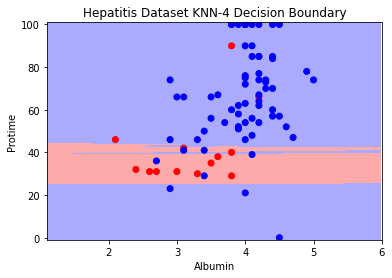

In [53]:
reduced_data = np.take(hepatitis_x, [16, 17], axis=-1)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

knn = KNN(K=4, dist_fn=euclidean)
knn.fit(reduced_data, hepatitis_y.astype('int64'))
probs_test, knns = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = np.argmax(probs_test, 1)
Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
plt.clf()

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=hepatitis_y, cmap=cmap_bold)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("Albumin")
plt.ylabel("Protime")
plt.title("Hepatitis Dataset KNN-4 Decision Boundary")
plt.show()

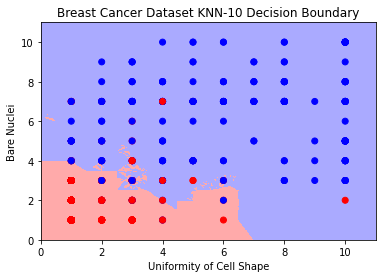

In [54]:
reduced_data = np.take(breast_cancer_x, [3, 6], axis=-1)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

knn = KNN(K=10, dist_fn=euclidean)
knn.fit(reduced_data, breast_cancer_y.astype('int64'))
probs_test, knns = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = np.argmax(probs_test, 1)
Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
plt.clf()

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=breast_cancer_y, cmap=cmap_bold)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("Uniformity of Cell Shape")
plt.ylabel("Bare Nuclei")
plt.title("Breast Cancer Dataset KNN-10 Decision Boundary")
plt.show()

## Decision Tree Boundaries

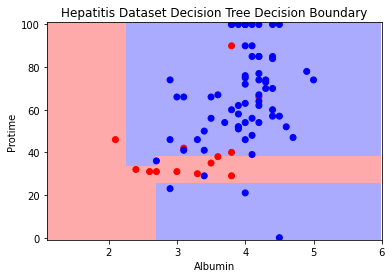

In [55]:
reduced_data = np.take(hepatitis_x, [16, 17], axis=-1)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

decision_tree = DecisionTree(max_depth=3, cost_fn=misclassification_cost)
decision_tree.fit(reduced_data, hepatitis_y.astype('int64'))
probs_test = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])

Z = np.argmax(probs_test, 1)
Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
plt.clf()

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=hepatitis_y, cmap=cmap_bold)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("Albumin")
plt.ylabel("Protime")
plt.title("Hepatitis Dataset Decision Tree Decision Boundary")
plt.show()

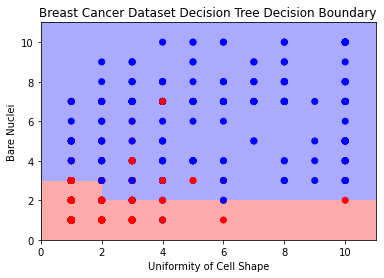

In [56]:
reduced_data = np.take(breast_cancer_x, [3, 6], axis=-1)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

decision_tree = DecisionTree(max_depth=4, cost_fn=entropy_cost)
decision_tree.fit(reduced_data, breast_cancer_y.astype('int64'))
probs_test = decision_tree.predict(np.c_[xx.ravel(), yy.ravel()])

Z = np.argmax(probs_test, 1)
Z = Z.reshape(xx.shape)

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
plt.clf()

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=breast_cancer_y, cmap=cmap_bold)

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel("Uniformity of Cell Shape")
plt.ylabel("Bare Nuclei")
plt.title("Breast Cancer Dataset Decision Tree Decision Boundary")
plt.show()